# Two Moons Simformer Conditional Flow Matching Example

This notebook demonstrates how to train and sample from a conditional flow-matching model on the Two Moons task using JAX and Flax. We cover environment setup, data generation, model definition, training, sampling, and evaluation.

## 1. Environment Setup

We set up the notebook environment, import required libraries, and configure JAX for CPU or GPU usage. This section also ensures compatibility with Google Colab.

In [1]:
# Check if running on Colab and install dependencies if needed
try:
    import google.colab
    colab = True
except ImportError:
    colab = False

if colab:
    # Install required packages and clone the repository
    %pip install "gensbi_examples[cuda12] @ git+https://github.com/aurelio-amerio/GenSBI-examples"
    !git clone https://github.com/aurelio-amerio/GenSBI-examples
    %cd GenSBI-examples/examples/sbi-benchmarks/two_moons

In [2]:
# load autoreload extension
%load_ext autoreload
%autoreload 2

In [3]:
# Set JAX backend (use 'cuda' for GPU, 'cpu' otherwise)
import os
# os.environ['JAX_PLATFORMS']="cuda"
os.environ['JAX_PLATFORMS']="cpu"

In [4]:
experiment_id = 1

### Set Training and Model Restoration Flags

Configure whether to restore a pretrained model or train from scratch.

In [5]:
restore_model=True
train_model=False

### Set Checkpoint Directory

Specify the directory for saving and restoring model checkpoints.

In [6]:
import orbax.checkpoint as ocp
# get the current notebook path
notebook_path = os.getcwd()
checkpoint_dir = f"/home/zaldivar/symlinks/aure/Github/GenSBI-examples/examples/sbi-benchmarks/two_moons/checkpoints/two_moons_flow_flux"
# checkpoint_dir = f"/home/zaldivar/symlinks/aure/Github/GenSBI-examples/examples/sbi-benchmarks/two_moons/old/checkpoints/two_moons_simformer"
os.makedirs(checkpoint_dir, exist_ok=True)

## 2. Library Imports and JAX Mesh Setup

Import required libraries and set up the JAX mesh for sharding.

In [7]:
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from flax import nnx

from numpyro import distributions as dist
import numpy as np


/home/zaldivar/miniforge3/envs/gensbi/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 3. Optimizer and Learning Rate Schedule Parameters

Define optimizer hyperparameters and learning rate scheduling.

## 4. Task and Dataset Setup

Define the Two Moons task and prepare training and validation datasets.

In [8]:
from gensbi.utils.plotting import plot_marginals

### Define the Task

In [9]:
from gensbi_examples.tasks import TwoMoons
task = TwoMoons()

./task_data/data_two_moons.npz already exists, skipping download.


In [10]:
obs, reference_samples = task.get_reference(num_observation=8)

#### Visualize Reference Samples

Plot the reference samples from the Two Moons task.

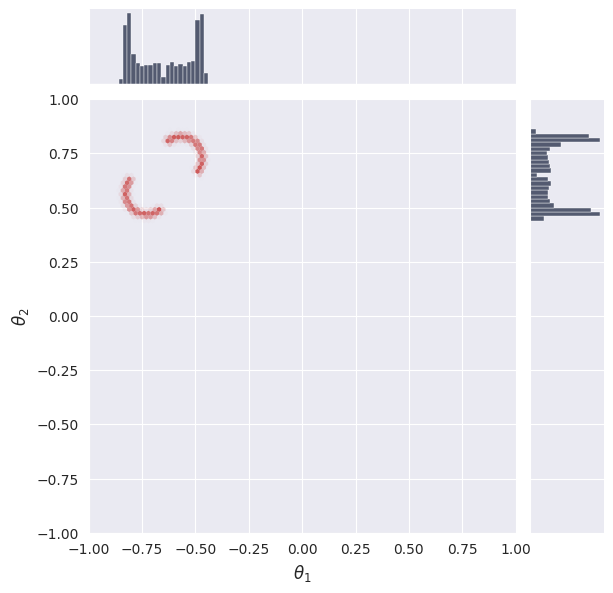

In [11]:
plot_marginals(np.asarray(reference_samples, dtype=np.float32), gridsize=100,range=[(-1.,1.),(-1.,1.)], backend="seaborn", plot_levels=False)
plt.show()

## 5. Dataset Preparation

Create training and validation datasets for the model.

In [12]:
# make a dataset
nsamples = int(1e5)

In [13]:
batch_size = 32 # the model greatly benefits from larger batch sizes to avoid overfitting, but this is limited by the GPU memory
train_dataset = task.get_train_dataset(batch_size)
val_dataset = task.get_val_dataset()

dataset_iter = iter(train_dataset)
val_dataset_iter = iter(val_dataset)

In [14]:
next(dataset_iter).shape, next(val_dataset_iter).shape

((32, 4, 1), (512, 4, 1))

## 6. Model Definition

Define the Simformer model and the conditional flow-matching loss.

**Note:**  
- The model uses *edge masks* as attention masks, which are crucial for controlling which variables are attended to during training and inference. These masks enable both posterior estimation (conditioning on observed data) and unconditional density estimation (no conditioning).
- The *marginalization* function is used to construct edge masks that marginalize out arbitrary variables, allowing the model to learn and evaluate arbitrary marginal distributions.

In [15]:
from gensbi.models import  Flux1Params
from gensbi.recipes import Flux1FlowPipeline

In [25]:
import yaml

config = "/home/zaldivar/symlinks/aure/Github/GenSBI-examples/examples/sbi-benchmarks/two_moons/config_flow_flux.yaml"

# Load config
with open(config, "r") as f:
    config = yaml.safe_load(f)

In [26]:
dim_obs = task.dim_obs.item()
dim_cond = task.dim_cond.item()

dim_joint = task.dim_joint.item()
node_ids = jnp.arange(dim_joint)

In [27]:
train_params = config.get("training", {})
experiment_id = train_params.get("experiment_id", 3)
restore_model = train_params.get("restore_model", False)
train_model = train_params.get("train_model", True)
batch_size = train_params.get("batch_size", 4096)
nsteps = train_params.get("nsteps", 10000)
nepochs = train_params.get("nepochs", 3)
multistep = train_params.get("multistep", 1)
early_stopping = train_params.get("early_stopping", True)
print_every = train_params.get("print_every", 100)

In [28]:


# Optimizer parameters
opt_params = config.get("optimizer", {})
PATIENCE = opt_params.get("patience", 10)
COOLDOWN = opt_params.get("cooldown", 2)
FACTOR = opt_params.get("factor", 0.5)
ACCUMULATION_SIZE = opt_params.get("accumulation_size", 100)
RTOL = opt_params.get("rtol", 1e-4)
MAX_LR = opt_params.get("max_lr", 1e-3)
MIN_LR = opt_params.get("min_lr", 0.0)
MIN_SCALE = MIN_LR / MAX_LR if MAX_LR > 0 else 0.0

In [ ]:
model_params = config.get("model", {})
params = Flux1Params(
        in_channels=model_params.get("in_channels", 1),
        vec_in_dim=model_params.get("vec_in_dim", None),
        context_in_dim=model_params.get("context_in_dim", 1),
        mlp_ratio=model_params.get("mlp_ratio", 4),
        num_heads=model_params.get("num_heads", 4),
        depth=model_params.get("depth", 8),
        depth_single_blocks=model_params.get("depth_single_blocks", 16),
        axes_dim=model_params.get("axes_dim", [10]),
        qkv_bias=model_params.get("qkv_bias", True),
        obs_dim=dim_obs,
        cond_dim=dim_cond,
        theta=model_params.get("theta", (dim_obs+dim_cond)*10),
        rngs=nnx.Rngs(default=42),
        param_dtype=getattr(jnp, model_params.get("param_dtype", "float32")),
    )

In [30]:
default_training_config = Flux1FlowPipeline._get_default_training_config()

In [31]:
# checkpoint_dir = "/home/zaldivar/symlinks/aure/Github/GenSBI-examples/examples/sbi-benchmarks/two_moons/checkpoints/two_moons_flow_simformer"
# checkpoint_dir = "/home/zaldivar/symlinks/aure/Github/GenSBI-examples/tests/ckpt-test"

default_training_config["checkpoint_dir"] = checkpoint_dir

In [32]:
pipeline = Flux1FlowPipeline(train_dataset, val_dataset, 2, 2, params=params, training_config=default_training_config)

In [33]:
pipeline.restore_model(1)

Restored model from checkpoint


## 9. Training Loop

Train the model using the defined optimizer and loss function. Early stopping and learning rate scheduling are used for efficient training.

In [34]:
# pipeline.train(rngs=nnx.Rngs(0), nsteps=10)

## 10. Training and Validation Loss Visualization

Plot the training and validation loss curves.

In [ ]:
# if train_model:
#     plt.plot(loss_array, label="train loss")
#     plt.plot(val_loss_array, label="val loss")
#     plt.xlabel("steps")
#     plt.ylabel("loss")
#     plt.legend()
#     plt.show()

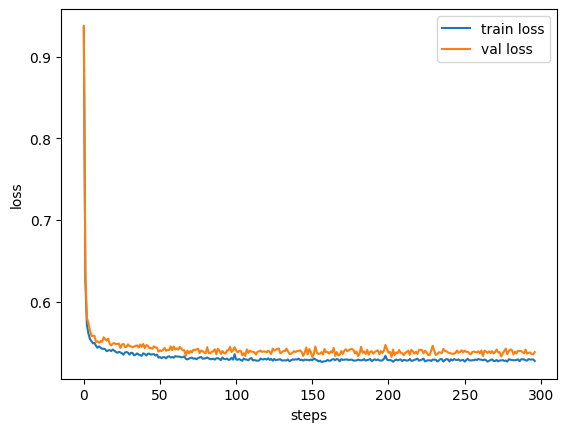

<!-- Optionally, you can display a sample image here if desired -->

## 12. Posterior Sampling

Sample from the posterior distribution using the trained model and visualize the results.

In [35]:
# we want to do conditional inference. We need an observation for which we want to ocmpute the posterior
def get_samples(idx, nsamples=10_000, use_ema=False, key=None):
    observation, reference_samples = task.get_reference(idx)
    true_param = jnp.array(task.get_true_parameters(idx))

    if key is None:
        key = jax.random.PRNGKey(42)

    samples = pipeline.sample(key, observation, nsamples, use_ema=use_ema)
    return samples, true_param, reference_samples

In [36]:
samples, true_param, reference_samples =  get_samples(8)

### Visualize Posterior Samples

Plot the posterior samples as a 2D histogram.

In [37]:
from gensbi.utils.plotting import plot_marginals, plot_2d_dist_contour

<Figure size 640x480 with 0 Axes>

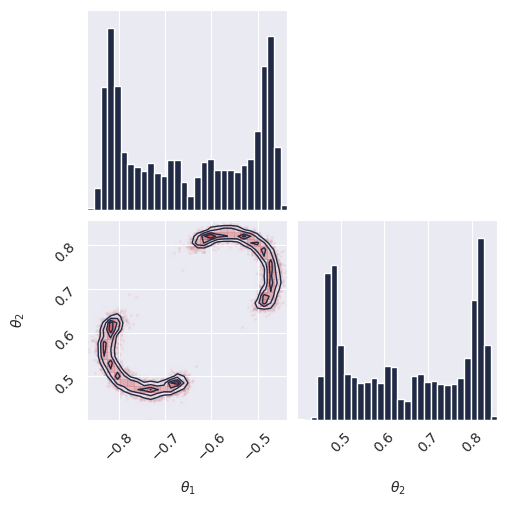

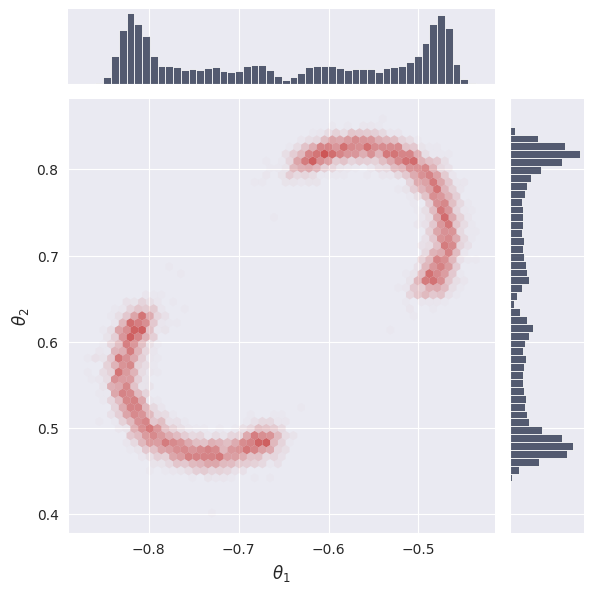

In [53]:
plot_marginals(samples, plot_levels=True, gridsize=30)
plt.show()

plot_marginals(samples, plot_levels=False, gridsize=50, backend="seaborn")
plt.show()

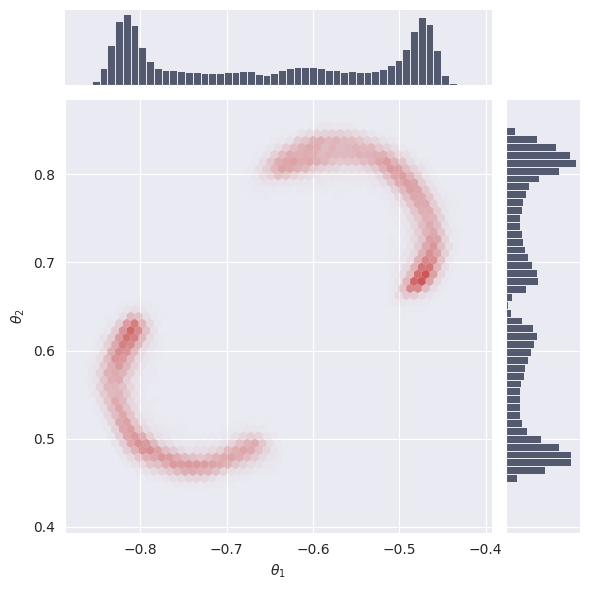